# Proof splitting

Here we showcase how to split a larger circuit into multiple smaller proofs. This is useful if you want to prove over multiple machines, or if you want to split a proof into multiple parts to reduce the memory requirements.

We showcase how to do this in the case where:
- intermediate calculations need to be kept secret (but not blinded !) and we need to use the low overhead kzg commitment scheme detailed [here](https://blog.ezkl.xyz/post/commits/) to stitch the circuits together.


First we import the necessary dependencies and set up logging to be as informative as possible. 

In [1]:
# check if notebook is in colab
try:
    # install ezkl
    import google.colab
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "ezkl"])
    subprocess.check_call([sys.executable, "-m", "pip", "install", "tf2onnx"])
    subprocess.check_call([sys.executable, "-m", "pip", "install", "onnx"])

# rely on local installation of ezkl if the notebook is not in colab
except:
    pass

# make sure you have the dependencies required here already installed
import ezkl
import os
import json
import time
import random
import logging

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist

# uncomment for more descriptive logging 
# FORMAT = '%(levelname)s %(name)s %(asctime)-15s %(filename)s:%(lineno)d %(message)s'
# logging.basicConfig(format=FORMAT)
# logging.getLogger().setLevel(logging.INFO)

# Can we build a simple GAN that can produce all 10 mnist digits?

In [2]:

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = [x/255.0 for x in [x_train, x_test]]
y_train, y_test = [tf.keras.utils.to_categorical(x) for x in [y_train, y_test]]

In [3]:
opt = Adam()
ZDIM = 100

# discriminator
# 0 if it's fake, 1 if it's real
x = in1 = Input((28,28))
x = Reshape((28,28,1))(x)

x = Conv2D(64, (5,5), padding='same', strides=(2,2))(x)
x = BatchNormalization()(x)
x = ELU()(x)

x = Conv2D(128, (5,5), padding='same', strides=(2,2))(x)
x = BatchNormalization()(x)
x = ELU()(x)

x = Flatten()(x)
x = Dense(128)(x)
x = BatchNormalization()(x)
x = ELU()(x)
x = Dense(1, activation='sigmoid')(x)
dm = Model(in1, x)
dm.compile(opt, 'binary_crossentropy')
dm.summary()

# generator, output digits
x = in1 = Input((ZDIM,))

x = Dense(7*7*64)(x)
x = BatchNormalization()(x)
x = ELU()(x)
x = Reshape((7,7,64))(x)

x = Conv2DTranspose(128, (5,5), strides=(2,2), padding='same')(x)
x = BatchNormalization()(x)
x = ELU()(x)

x = Conv2DTranspose(1, (5,5), strides=(2,2), padding='same')(x)
x = Activation('sigmoid')(x)
x = Reshape((28,28))(x)

gm = Model(in1, x)
gm.compile('adam', 'mse')
gm.summary()

opt = Adam()

# GAN
dm.trainable = False
x = dm(gm.output)
tm = Model(gm.input, x)
tm.compile(opt, 'binary_crossentropy')

dlosses, glosses = [], []

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 14, 14, 64)     │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ elu (ELU)                       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 7, 7, 128)      │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ elu_1 (ELU)                     │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       802,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ elu_2 (ELU)                     │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,010,945 (3.86 MB)

 Trainable params: 1,010,305 (3.85 MB)

 Non-trainable params: 640 (2.50 KB)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3136)           │       316,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 3136)           │        12,544 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ elu_3 (ELU)                     │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 14, 14, 128)    │       204,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 14, 14, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ elu_4 (ELU)                     │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 28, 28, 1)      │         3,201 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 28, 28)         │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 537,921 (2.05 MB)

 Trainable params: 531,393 (2.03 MB)

 Non-trainable params: 6,528 (25.50 KB)

   0: dloss:  0.8383   gloss:  2.3304
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


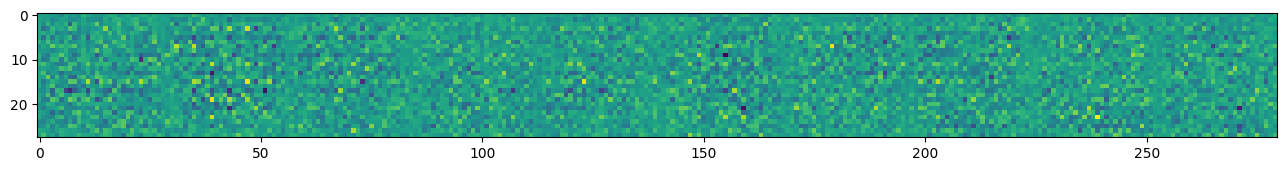

In [4]:
import numpy as np
from matplotlib.pyplot import figure, imshow, show

BS = 256

# GAN training loop
# make larger if you want it to look better
for i in range(1):
  # train discriminator
  dm.trainable = True
  real_i = x_train[np.random.choice(x_train.shape[0], BS)]
  fake_i = gm.predict_on_batch(np.random.normal(0,1,size=(BS,ZDIM)))
  dloss_r = dm.train_on_batch(real_i, np.ones(BS))
  dloss_f = dm.train_on_batch(fake_i, np.zeros(BS))
  dloss = (dloss_r + dloss_f)/2

  # train generator
  dm.trainable = False
  gloss_0 = tm.train_on_batch(np.random.normal(0,1,size=(BS,ZDIM)), np.ones(BS))
  gloss_1 = tm.train_on_batch(np.random.normal(0,1,size=(BS,ZDIM)), np.ones(BS))
  gloss = (gloss_0 + gloss_1)/2

  if i%50 == 0:
    print("%4d: dloss:%8.4f   gloss:%8.4f" % (i, dloss, gloss))
  dlosses.append(dloss)
  glosses.append(gloss)
    
  if i%250 == 0:
    
    figure(figsize=(16,16))
    imshow(np.concatenate(gm.predict(np.random.normal(size=(10,ZDIM))), axis=1))
    show()

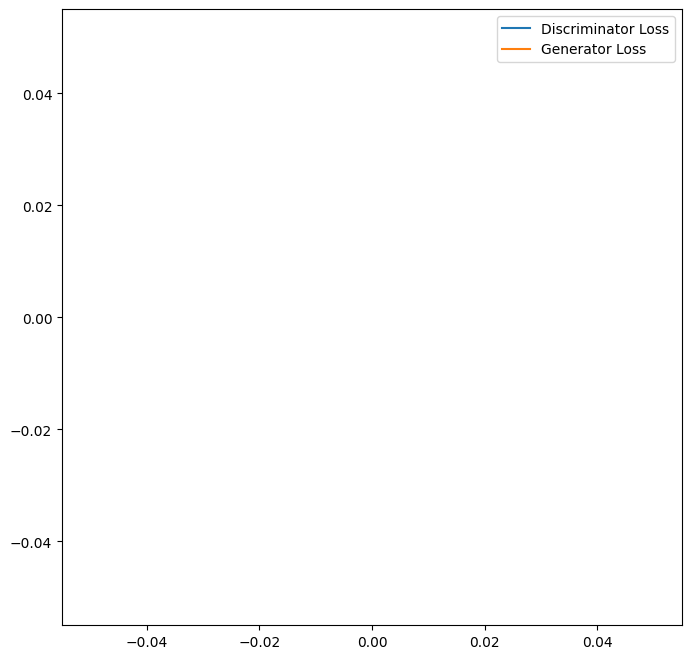

In [5]:
from matplotlib.pyplot import plot, legend
figure(figsize=(8,8))
plot(dlosses[100:], label="Discriminator Loss")
plot(glosses[100:], label="Generator Loss")
legend()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


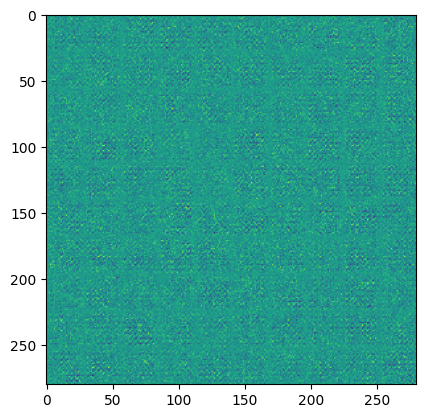

In [6]:
x = []
for i in range(10):
  x.append(np.concatenate(gm.predict(np.random.normal(size=(10,ZDIM))), axis=1))
imshow(np.concatenate(x, axis=0))

Now we export the _generator_ to onnx

In [7]:

import numpy as np
import tf2onnx
import tensorflow as tf
import json

# split the model into 3 parts
gm2 = tf.keras.models.Sequential(gm.layers[0:4])
# display gm2 
gm2.summary()
gm2.output_names=['output']

gm3 = tf.keras.models.Sequential(gm.layers[4:8])
#  display gm3
gm3.summary() 
gm3.output_names=['output']

gm4 = tf.keras.models.Sequential(gm.layers[8:])
# display gm4
gm4.summary()
gm4.output_names=['output'] 

# After training, export to onnx (network.onnx) and create a data file (input.json)
x = 0.1*np.random.rand(1,*[1, ZDIM])
inter_x1 = gm2(x[0])
inter_x2 = gm3(inter_x1)

output_path = "network_split_0.onnx"
spec = tf.TensorSpec([1, ZDIM], tf.float32, name='input_0')
tf2onnx.convert.from_keras(gm2, input_signature=[spec], inputs_as_nchw=['input_0'], opset=12, output_path=output_path)
output_path = "network_split_1.onnx"
spec = tf.TensorSpec(inter_x1.shape, tf.float32, name='elu1')
tf2onnx.convert.from_keras(gm3, input_signature=[spec], inputs_as_nchw=['input_1'], opset=12, output_path=output_path)
output_path = "network_split_2.onnx"
spec = tf.TensorSpec(inter_x2.shape, tf.float32, name='elu2')
tf2onnx.convert.from_keras(gm4, input_signature=[spec], inputs_as_nchw=['input_2'], opset=12, output_path=output_path)

data_array = x.reshape([-1]).tolist()

data = dict(input_data = [data_array])
inter_x1 = inter_x1.numpy().reshape([-1]).tolist()
inter_x2 = inter_x2.numpy().reshape([-1]).tolist()
data_2 = dict(input_data = [inter_x1])
data_3 = dict(input_data = [inter_x2])

    # Serialize data into file:
data_path = os.path.join('gan_input_0.json')
json.dump( data, open(data_path, 'w' ))
data_path = os.path.join('gan_input_1.json')
json.dump( data_2, open(data_path, 'w' ))
data_path = os.path.join('gan_input_2.json')
json.dump( data_3, open(data_path, 'w' ))



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 3136)           │       316,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 3136)           │        12,544 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ elu_3 (ELU)                     │ (None, 3136)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,280 (1.26 MB)

 Trainable params: 323,008 (1.23 MB)

 Non-trainable params: 6,272 (24.50 KB)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_1 (Reshape)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 14, 14, 128)    │       204,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 14, 14, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ elu_4 (ELU)                     │ (None, 14, 14, 128)    │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,440 (802.50 KB)

 Trainable params: 205,184 (801.50 KB)

 Non-trainable params: 256 (1.00 KB)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_transpose_1              │ (None, 28, 28, 1)      │         3,201 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 28, 28)         │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,201 (12.50 KB)

 Trainable params: 3,201 (12.50 KB)

 Non-trainable params: 0 (0.00 B)

transpose_input for input_0: shape must be rank 4, ignored


###  KZG commitment intermediate calculations

the visibility parameters are:
- `input_visibility`: "polycommit"
- `param_visibility`: "public"
- `output_visibility`: polycommit

In [8]:
import ezkl

srs_path = os.path.join('kzg.srs')

run_args = ezkl.PyRunArgs()
run_args.input_visibility = "polycommit"
run_args.param_visibility = "fixed"
run_args.output_visibility = "polycommit"
run_args.variables = [("batch_size", 1)]
run_args.input_scale = 0
run_args.param_scale = 0
run_args.logrows = 18

ezkl.get_srs(logrows=run_args.logrows, commitment=ezkl.PyCommitments.KZG)


<Future pending cb=[<builtins.PyDoneCallback object at 0x34fc48390>()]>

## Circuit compilation

In [9]:
# iterate over each submodel gen-settings, compile circuit and setup zkSNARK

async def setup(i):
    print("Setting up split model "+str(i))
    # file names
    model_path = os.path.join('network_split_'+str(i)+'.onnx')
    settings_path = os.path.join('settings_split_'+str(i)+'.json')
    data_path =  os.path.join('gan_input_'+str(i)+'.json')
    compiled_model_path = os.path.join('network_split_'+str(i)+'.compiled')
    pk_path = os.path.join('test_split_'+str(i)+'.pk')
    vk_path = os.path.join('test_split_'+str(i)+'.vk')
    witness_path = os.path.join('witness_split_'+str(i)+'.json')

    if i > 0:
         prev_witness_path = os.path.join('witness_split_'+str(i-1)+'.json')
         witness = json.load(open(prev_witness_path, 'r'))
         data = dict(input_data = witness['outputs'])
         # Serialize data into file:
         json.dump(data, open(data_path, 'w' ))
    else:
         data_path = os.path.join('gan_input_0.json')

    # generate settings for the current model
    res = ezkl.gen_settings(model_path, settings_path, py_run_args=run_args)
    res = await ezkl.calibrate_settings(data_path, model_path, settings_path, "resources", scales=[run_args.input_scale], max_logrows=run_args.logrows)
    assert res == True

    # load settings and print them to the console
    settings = json.load(open(settings_path, 'r'))
    settings['run_args']['logrows'] = run_args.logrows
    json.dump(settings, open(settings_path, 'w' ))

    res = ezkl.compile_circuit(model_path, compiled_model_path, settings_path)


    res = ezkl.setup(
         compiled_model_path,
         vk_path,
         pk_path,
      )

    assert res == True
    assert os.path.isfile(vk_path)
    assert os.path.isfile(pk_path)
    res = await ezkl.gen_witness(data_path, compiled_model_path, witness_path, vk_path)
    run_args.input_scale = settings["model_output_scales"][0]

for i in range(3):
    await setup(i)


Setting up split model 0




 <------------- Numerical Fidelity Report (input_scale: 0, param_scale: 0, scale_input_multiplier: 10) ------------->

+---------------+--------------+-------------+--------------+----------------+------------------+---------------+-----------------+--------------------+--------------------+------------------------+
| mean_error    | median_error | max_error   | min_error    | mean_abs_error | median_abs_error | max_abs_error | min_abs_error   | mean_squared_error | mean_percent_error | mean_abs_percent_error |
+---------------+--------------+-------------+--------------+----------------+------------------+---------------+-----------------+--------------------+--------------------+------------------------+
| 0.00004752255 | -0.012598574 | 0.056053344 | -0.048946142 | 0.012820076    | 0.012598574      | 0.056053344   | 0.0000010610092 | 0.0002609586       | 1                  | 1                      |
+---------------+--------------+-------------+--------------+----------------+-----

Setting up split model 1


## Proof generation

In [ ]:
# GENERATE A PROOF

print("Proving split models")


def prove_model(i): 
    proof_path = os.path.join('proof_split_'+str(i)+'.json')
    witness_path = os.path.join('witness_split_'+str(i)+'.json')
    compiled_model_path = os.path.join('network_split_'+str(i)+'.compiled')
    pk_path = os.path.join('test_split_'+str(i)+'.pk')
    vk_path = os.path.join('test_split_'+str(i)+'.vk')
    settings_path = os.path.join('settings_split_'+str(i)+'.json')

    res = ezkl.prove(
            witness_path,
            compiled_model_path,
            pk_path,
            proof_path,
            "for-aggr",
        )

    print(res)
    assert os.path.isfile(proof_path)

    # Verify the proof
    if i > 0:
        # swap the proof commitments if we are not the first model
        prev_witness_path = os.path.join('witness_split_'+str(i-1)+'.json')
        prev_witness = json.load(open(prev_witness_path, 'r'))

        witness = json.load(open(witness_path, 'r'))

        print(prev_witness["processed_outputs"])
        print(witness["processed_inputs"])

        witness["processed_inputs"] = prev_witness["processed_outputs"]

        # now save the witness
        with open(witness_path, "w") as f:
            json.dump(witness, f)

        res = ezkl.swap_proof_commitments(proof_path, witness_path)

    res = ezkl.verify(
            proof_path,
            settings_path,
            vk_path,
        )

    assert res == True
    print("verified")


for i in range(3):
    print("----- proving split "+str(i))
    prove_model(i)

You can also mock aggregate the split proofs into a single proof. This is useful if you want to verify the proof on chain at a lower cost. Here we mock aggregate the proofs to save time. You can use other notebooks to see how to aggregate in full ! 

In [ ]:
# now mock aggregate the proofs
proofs = []
for i in range(3):
    proof_path = os.path.join('proof_split_'+str(i)+'.json')
    proofs.append(proof_path)

ezkl.mock_aggregate(proofs, logrows=22, split_proofs = True)